In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import traja

In [2]:
data = np.load('newrawdata.npy',allow_pickle=True)
flynum = data[1].shape[0] #384

In [3]:
xcm = data[3] #x center of mass location #(384,)
ycm = data[5]
end_time = data[13]
t_offset = 1.0/3.0 
t = data[16] - t_offset

In [4]:
# ? seconds before 1st meal -> 1st meal
first_meal_end = np.array([end_time[i][0] for i in range(flynum)])

# get that trajectory
x_traj = []
y_traj = []
for i in range(flynum):
    idx = (t[i] >= (first_meal_end[i])) & (t[i] <= (first_meal_end[i] + 5))   #5 seconds after 1st meal
    x_traj.append(xcm[i][idx])
    y_traj.append(ycm[i][idx])
x_traj = np.array(x_traj,dtype=object)
y_traj = np.array(y_traj,dtype=object)

def traj(flyno):
    return np.vstack((x_traj[flyno], y_traj[flyno]))

In [5]:
from traja import TrajaCollection
def create_df(flyno):
    x_fly = traj(flyno)[0]
    y_fly = traj(flyno)[1]
    d = {'x': x_fly, 'y': y_fly}
    df = pd.DataFrame(data=d)
    df = traja.TrajaDataFrame(df)
    return df

# Create a dictionary of DataFrames, with 'id' as key.
keys = np.arange(flynum)
all_values = [] #create values - i.e. df for each fly
for n in range(flynum):
    all_values.append(create_df(n))

df_all = {}
for i in range(flynum):
    df_all[i] = all_values[i]

# Create a TrajaCollection df (x,y,id)
trjs = TrajaCollection(df_all)

trjs = trjs.rename({'id': 'ID'}, axis=1)

In [6]:
trjs

,x,y,ID
0,-0.111696,0.217172,0
1,-0.111158,0.217525,0
2,-0.110690,0.217826,0
3,-0.110300,0.218071,0
4,-0.109992,0.218255,0
...,...,...,...
145,0.039151,0.085286,383
146,0.039080,0.085352,383
147,0.039010,0.085426,383
148,0.038941,0.085506,383


In [7]:
batch_size = 10 # How many sequences to train every step. Constrained by GPU memory.
num_past = 8 # How many time steps from which to learn the time series
num_future = 8 # How many time steps to predict
split_by_id = False 

In [8]:
df_used = trjs

dataloaders = traja.dataset.MultiModalDataLoader(df_used, batch_size=batch_size, n_past=num_past,
n_future=num_future, num_workers=0, split_by_id=split_by_id)

In [9]:
from traja.models.predictive_models.lstm import LSTM
input_size = 2 # Number of input dimensions (normally x, y)
output_size = 2 # Same as input_size when predicting
num_layers = 2 # Number of LSTM layers. Deeper learns more complex patterns but overfits.
hidden_size = 32 # Width of layers. Wider learns bigger patterns but overfits. Try 32, 64, 128, 256, 512
dropout = 0.1 # Ignore some network connections. Improves generalisation.


model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             output_size=output_size,
             dropout=dropout,
             batch_size=batch_size)

In [10]:
from traja.models.train import HybridTrainer

optimizer_type = 'Adam' # Nonlinear optimiser with momentum
loss_type = 'huber'

# Trainer
trainer = HybridTrainer(model=model,
                        optimizer_type=optimizer_type,
                        loss_type=loss_type)
# Train the model
trainer.fit(dataloaders, model_save_path='./model.pt', epochs=10, training_mode='forecasting')

Epoch 1 | forecasting loss 0.23712600767612457
Epoch 2 | forecasting loss 0.06041974574327469
Epoch 3 | forecasting loss 0.032953400164842606
Epoch 4 | forecasting loss 0.021218130365014076
Epoch 5 | forecasting loss 0.014141074381768703
Epoch 6 | forecasting loss 0.011484170332551003
Epoch 7 | forecasting loss 0.009829467162489891
Epoch 8 | forecasting loss 0.00823614839464426
Epoch 9 | forecasting loss 0.007301200181245804
====> Mean Test set forecasting loss: 0.0062
Epoch 10 | forecasting loss 0.006511840969324112
Model and hyperparameters saved at /Users/alisonsin/Desktop/thesis/fly


In [11]:
validation_loader = dataloaders['sequential_validation_loader']
trainer.validate(validation_loader)

====> Mean Validation set generator loss: 0.0265


(0.02647227254055906, 0.0, 0.0)

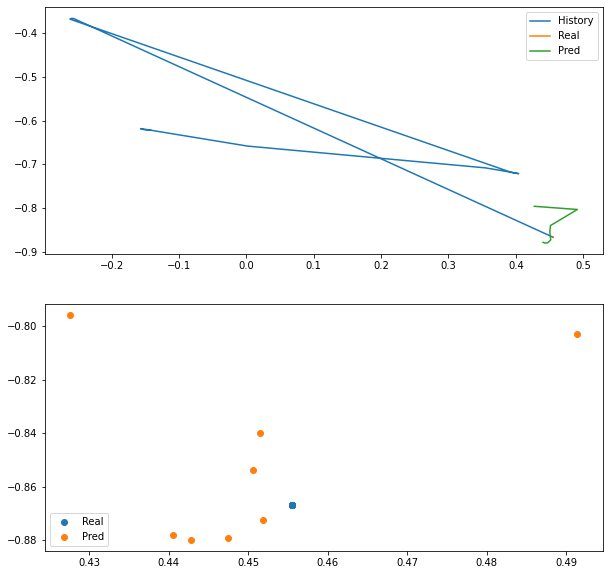

In [12]:
from traja.plotting import plot_prediction
batch_index = 0
plot_prediction(model, validation_loader, batch_index)

In [13]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pandas as pd


from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from CustomDataset import customdataset

In [14]:
#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
#Creating train_csv
train_df = pd.DataFrame(columns=["img_name","label"])
train_df["img_name"] = ['fly_0.jpg','fly_1.jpg','fly_2.jpg','fly_3.jpg',
                        'fly_4.jpg','fly_5.jpg','fly_6.jpg','fly_7.jpg',
                        'fly_8.jpg','fly_9.jpg']
train_df["label"] = [1,1,1,1,1,1,1,1,1,1]
train_df.to_csv (r'train_csv.csv', index = False, header=True)

In [16]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5))])

In [17]:
#Load data
dataset = customdataset(csv_file = '/Users/alisonsin/Desktop/thesis/fly/train_csv.csv',
                       root_dir = '/Users/alisonsin/Desktop/thesis/fly/fly_img', #of image
                       transform = transform)

In [18]:
train_set, test_set = torch.utils.data.random_split(dataset, [3,7])

train_loader = DataLoader(dataset = train_set, batch_size = 3, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size = 3, shuffle=True)

In [19]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images[:, :1, :,:]/255 #BandW
print(torch.min(images), torch.max(images))
print(images.shape, labels.shape)  #3 images, 1 channel, 28*28 pixel

tensor(-0.0017) tensor(0.0039)
torch.Size([3, 1, 28, 28]) torch.Size([3])


## Before being inside Encoder

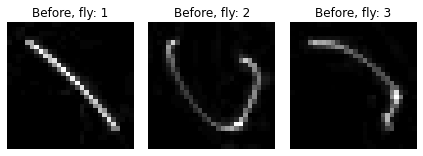

In [20]:
figure = plt.figure(figsize=(8, 8))
num_of_images = 3
for index in range(1, num_of_images+1):
    plt.subplot(4, 4, index)
    plt.axis('off')
    plt.tight_layout()
    plt.title('Before, fly: ' + str(index))
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,1) #N, 19 -> N, 10
            )
        self.decoder = nn.Sequential(
            nn.Linear(1, 28*28),
            nn.Sigmoid()
            )
        
    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

In [22]:
model = Autoencoder()
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [23]:
import tensorflow as tf
num_epochs = 10
outputs= []
for epoch in range(num_epochs):
    for (img, _) in train_loader:
        img = img.reshape(-1,28*28)
        
        recon = model(img)
        #loss = criterion(recon,img)
        inn = img.detach().numpy()
        outt = recon.detach().numpy()
        
        loss = tf.reduce_sum(tf.square(inn - outt)) 
        
        optimizer.zero_grad()
        
        #loss.backward()
        optimizer.step()
    #outputs.append((epoch, img, recon))
    outputs.append(recon)

/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

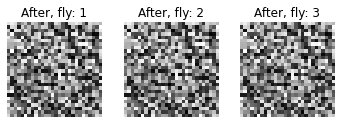

In [24]:
imgs = outputs[10-1].detach().numpy()
imgs = imgs.reshape(-1, 28,28)


figure = plt.figure(figsize=(8, 8))
num_of_images = 3
for index in range(1, num_of_images+1):
    plt.subplot(4, 4, index)
    plt.title('After, fly: ' + str(index))
    plt.axis('off')
    plt.imshow(imgs[index-1], cmap='gray_r')

In [25]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            #nn.Linear(28*28,1), #N, 19 -> N, 10
            #nn.ReLU(),
            #nn.Linear(8,4),
            #nn.ReLU(),
            #nn.Linear(4,2)
            )
        
        
        self.decoder = nn.Sequential(
            #nn.Linear(2,4), #N, 19 -> N, 10
            #nn.ReLU(),
            #nn.Linear(4,8),
            #nn.ReLU(),
            #nn.Linear(1, 28*28),
            #nn.Sigmoid()
            )
        
    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded